In [ ]:
import zipfile
import os

# HWData.zip dosyasını çıkartma
zip_path = 'HWData.zip'
extract_path = 'HWData'

# Eğer dosya zaten çıkartılmamışsa çıkartalım
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Zip dosyası başarıyla çıkartıldı.")
else:
    print("Zip dosyası zaten çıkartılmış.")


Zip dosyası başarıyla çıkartıldı.


Confusion Matrix:
 [[44  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [13  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [11  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 8  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
Accuracy: 0.36666666666666664


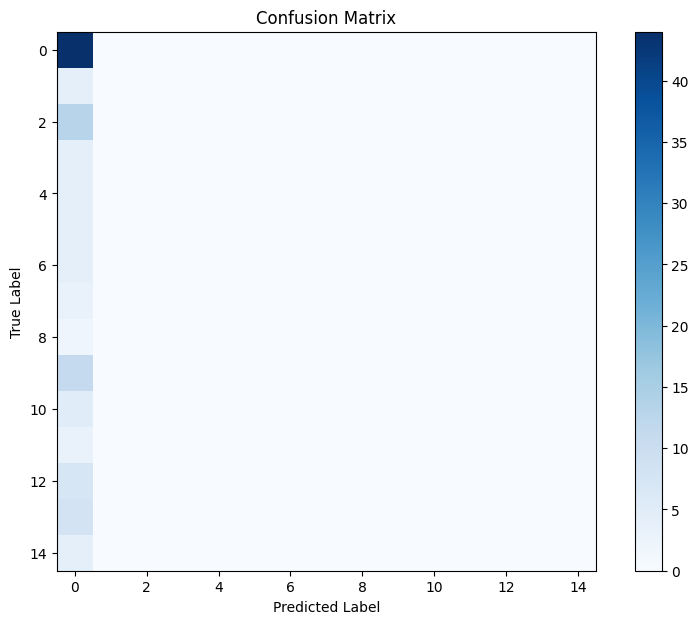

In [ ]:
import numpy as np
import cv2
from skimage.color import rgb2lab, rgb2gray
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
import os

# OpenCV'nin SIFT modülünü kullanmak için gerekli kütüphane
!pip install opencv-contrib-python

# Veri yollarını belirleme
train_dir = os.path.join('HWData', 'HWData/train')
test_dir = os.path.join('HWData', 'HWData/test')

# Resimleri ve etiketleri yükleme ve özellik çıkarma
def load_data_and_extract_features(data_dir):
    features = []
    labels = []
    sift = cv2.SIFT_create()
    for class_dir in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_dir)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (224, 224))
                img_lab = rgb2lab(img)
                img_gray = rgb2gray(img_lab).astype('uint8')

                # CLAHE ile kontrast artırma
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                img_gray = clahe.apply(img_gray)

                keypoints, descriptors = sift.detectAndCompute(img_gray, None)

                if descriptors is not None:
                    features.append(descriptors.flatten())
                    labels.append(class_dir)

    return features, np.array(labels)

# Eğitim ve test verilerini yükleyip özellik çıkarma
X_train, y_train = load_data_and_extract_features(train_dir)
X_test, y_test = load_data_and_extract_features(test_dir)

# Özellik vektörlerini sabit bir boyuta getirme
max_features = 20  # Sabit boyut olarak 500'ü seçiyoruz
X_train_padded = np.array([np.pad(x, (0, max_features - len(x)), 'constant') if len(x) < max_features else x[:max_features] for x in X_train])
X_test_padded = np.array([np.pad(x, (0, max_features - len(x)), 'constant') if len(x) < max_features else x[:max_features] for x in X_test])

# Özellik seçimi (SFS yöntemiyle)
n_features = max_features // 2  # Özellik sayısını yarıya indirme
sfs = SFS(svm.SVC(kernel='linear'), n_features_to_select=n_features, direction='forward')
sfs.fit(X_train_padded, y_train)

X_train_selected = sfs.transform(X_train_padded)
X_test_selected = sfs.transform(X_test_padded)

# SVM ile eğitim ve test
model = svm.SVC(kernel='linear', decision_function_shape='ovr')
model.fit(X_train_selected, y_train)

# Tahminler
y_pred = model.predict(X_test_selected)

# Karışıklık matrisi ve doğruluk hesaplama
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print('Confusion Matrix:\n', conf_matrix)
print('Accuracy:', accuracy)

# Karışıklık matrisini görselleştirme
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

